In [67]:
%load_ext autoreload
%autoreload 2
import warnings 
warnings.filterwarnings('ignore')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
import pandas as pd 
import torch

file_path = '/Users/lenoxherman/Tippers/tipDataSet/tip.csv'
# Extract the CSV file from the zip archive

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)


In [69]:
df


,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


In [70]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
def prepare_data(df):
  #removing columns that are not needed
  # df.drop('smoker', axis=1, inplace=True)
  day_mapping = {'Sun': 1, 'Sat': 1, 'Fri': 1, 'Thur':0}
  # Create a new column 'day_encoded' based on Weekday or Weekend
  df['day_encoded'] = df['day'].map(day_mapping)
  # Create a new column "time_encoded" based on Lunch or Dinner
  df['time_encoded'] = le.fit_transform(df['time'])
  # Creates a new column 'smoker_encoded' based on Yes or No
  df['smoker_encoded'] = le.fit_transform(df['smoker'])
  # Creates a new column "sex_encoded'" based on female or male
  df['sex_encoded'] = le.fit_transform(df['sex'])
  # Creates a new column 'percent_tip' based on the percentage of the tip amount
  df['percent_tip'] = (df['tip'] / df['total_bill']) * 100
  # Round the 'percent_tip' column to two decimal places
  df['percent_tip'] = df['percent_tip'].round()
  #makes groups for tips to 25+
  tip_groups = [0, 10, 15, 20, 25, float('inf')]
  label_tip_groups = ['0-10%', '10-15%', '15-20%', '20-25%', '25+']
  df['tip_groups'] = pd.cut(df['percent_tip'], bins = tip_groups, labels= label_tip_groups)
  df['tip_groups'] = df['tip_groups'].astype(str)
  df['tip_groups'] = df['tip_groups'].str.extract(r'(\d+)').astype(float)

  le.fit(df["tip_groups"])
  #turns the labels in 'tip' to a number
  y = le.transform(df["tip_groups"])
  #print(y)
  #removing 'tip' col bc now held by y
  df = df.drop(["tip_groups"], axis = 1)

#drop tip, and percent_tip?

  #converted into “one-hot encoded” 0-1 columns
  df = pd.get_dummies(df)
  return df, y
X_train, y_train = prepare_data(df)

In [71]:
df

,total_bill,tip,sex,smoker,day,time,size,day_encoded,time_encoded,smoker_encoded,sex_encoded,percent_tip,tip_groups
0,16.99,1.01,Female,No,Sun,Dinner,2,1,0,0,0,6.0,0.0
1,10.34,1.66,Male,No,Sun,Dinner,3,1,0,0,1,16.0,15.0
2,21.01,3.50,Male,No,Sun,Dinner,3,1,0,0,1,17.0,15.0
3,23.68,3.31,Male,No,Sun,Dinner,2,1,0,0,1,14.0,10.0
4,24.59,3.61,Female,No,Sun,Dinner,4,1,0,0,0,15.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3,1,0,0,1,20.0,15.0
240,27.18,2.00,Female,Yes,Sat,Dinner,2,1,0,1,0,7.0,0.0
241,22.67,2.00,Male,Yes,Sat,Dinner,2,1,0,1,1,9.0,0.0
242,17.82,1.75,Male,No,Sat,Dinner,2,1,0,0,1,10.0,0.0


## Visualizations

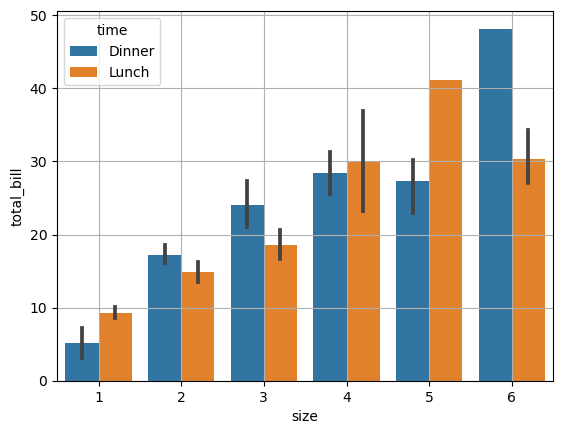

In [72]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.barplot(data = df, x = "size", y = "total_bill", hue = "time")

plt.title('')
plt.grid(True)
plt.show()

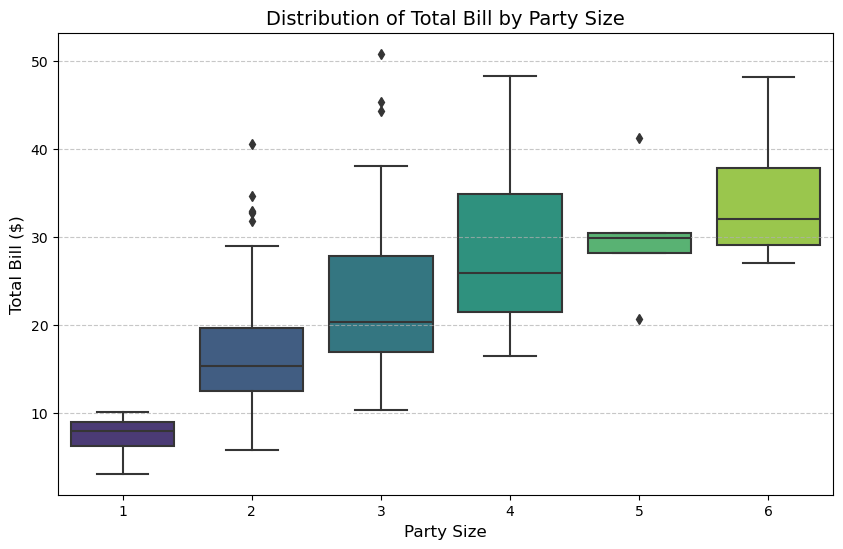

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='size', y='total_bill', data=df, palette='viridis')
plt.title('Distribution of Total Bill by Party Size', fontsize=14)
plt.xlabel('Party Size', fontsize=12)
plt.ylabel('Total Bill ($)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



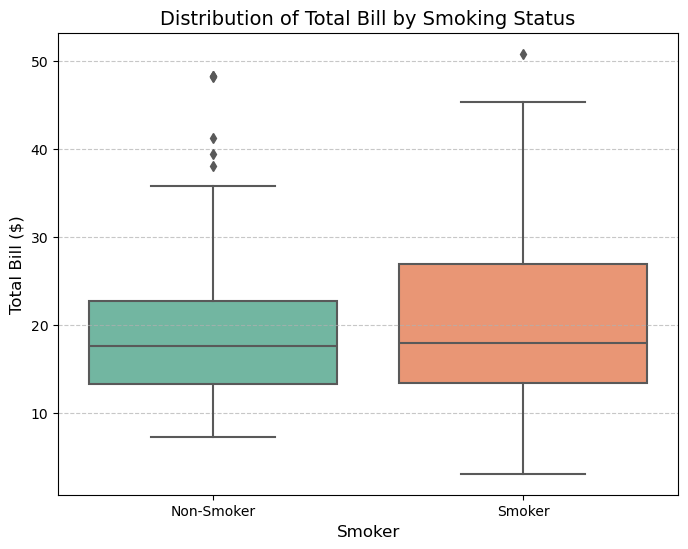

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.boxplot(x='smoker', y='total_bill', data=df, palette='Set2')
plt.title('Distribution of Total Bill by Smoking Status', fontsize=14)
plt.xlabel('Smoker', fontsize=12)
plt.ylabel('Total Bill ($)', fontsize=12)
plt.xticks([0, 1], ['Non-Smoker', 'Smoker'], fontsize=10)  # Customize x-axis labels
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


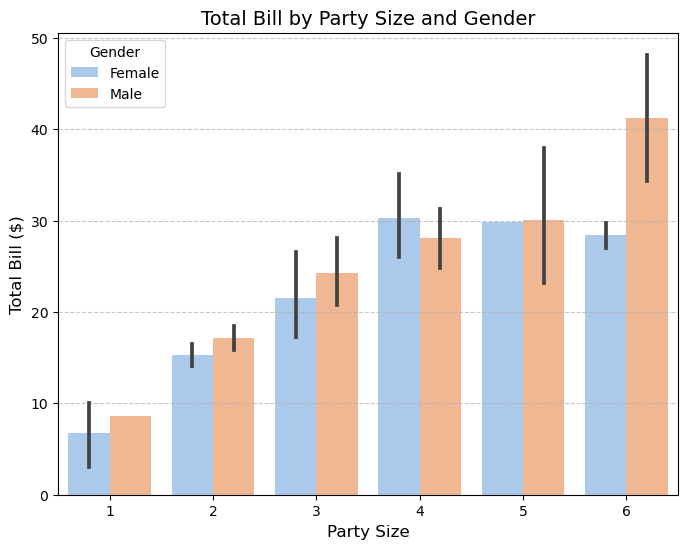

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.barplot(x='size', y='total_bill', hue='sex', data=df, palette='pastel')
plt.title('Total Bill by Party Size and Gender', fontsize=14)
plt.xlabel('Party Size', fontsize=12)
plt.ylabel('Total Bill ($)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Gender', fontsize=10, title_fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [76]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size = 0.2)

In [77]:

all_quan_cols = ["total_bill", "tip", "percent_tip", "size", "tip_groups", "day_encoded"]
all_qual_cols= ["sex", "smoker","day", "time"]

predictor_cols = ["size", "day_encoded", "time_encoded", "total_bill", "smoker_encoded",'sex_encoded']
target_col = ["tip_groups"]

X_train = df_train[predictor_cols]
y_train = df_train[target_col]

X_test = df_test[predictor_cols]
y_test = df_test[target_col]

In [78]:
print(df_train.shape)
print(df_test.shape)

(195, 13)
(49, 13)


# Basic Logistic Regression Score

### Basic Logistic Regression Score on Training Data

In [79]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()

result = LR.fit(X_train, y_train)
LR.fit(X_train, y_train)
LR.score(X_train, y_train)

0.4564102564102564

### Basic Logistic Regression Score on Testing Data

In [80]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()

result = LR.fit(X_test, y_test)
LR.fit(X_test, y_test)
LR.score(X_test, y_test)

0.46938775510204084

# Logistic Regression with Optimization Score

In [81]:
from sklearn.model_selection import cross_val_score
from GDO import LogisticRegression, GradientDescentOptimizer

In [82]:
# X_train_tensor = torch.DoubleTensor(X_train.values)
# y_train_tensor = torch.DoubleTensor(y_train.values)

import numpy as np 

X_train_tensor = X_train.values.double()
y_train_tensor = y_train.values.double()

LRO = LogisticRegression()
opt = GradientDescentOptimizer(LRO)

loss_vec = []

for _ in range(10000):
    loss_var = LRO.loss(X_train_tensor,y_train_tensor)
    loss_vec.append(loss_var)
    opt.step(X_train_tensor, y_train_tensor, alpha = 0.1, beta = 0.9) #optimizer with momentum


(195, 6)


TypeError: 'int' object is not callable

### Plotting data and checking the prediction at 10,000 iterations

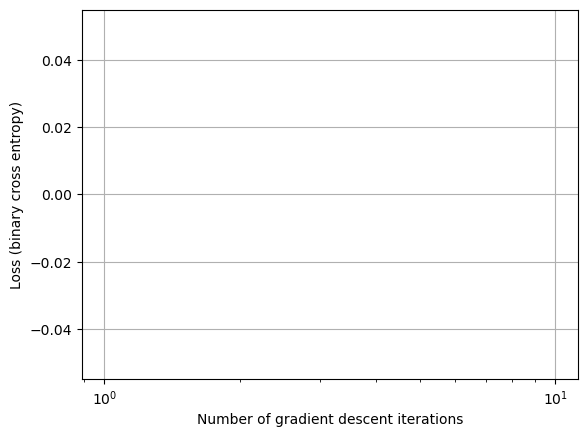

In [ ]:
plt.plot(torch.arange(1, len(loss_vec)+1), loss_vec, color = "black")
plt.semilogx()
plt.grid(True)
labs = plt.gca().set(xlabel = "Number of gradient descent iterations", ylabel = "Loss (binary cross entropy)")

In this graph, we can see that as we increase the number of gradient descent optimizer iterations, the graph flattens out to reach convergence.

In [ ]:
from GDO import LogisticRegression

LRO = LogisticRegression()

GDO_predict = (1.0 * (LRO.predict(X_train) == y_train)).mean()
print("Prediction Accuracy with Gradient Descent Optimizer Training Data: ", float(GDO_predict))

TypeError: 'int' object is not callable

### Running Gradient Descent on Testing Data

In [ ]:
from GDO import LogisticRegression

LRO = LogisticRegression()
# need to change x and y test to tensors for this to work, copy code from x_train and y_train from above


GDO_predict = (1.0 * (LRO.predict(X_test) == y_test)).mean()
print("Prediction Accuracy with Gradient Descent Optimizer Testing Data: ", float(GDO_predict))

TypeError: 'int' object is not callable

# Decision Tree Classifier Model Prediction Score

In [ ]:
from sklearn.tree import DecisionTreeClassifier

score_counter = 0
for i in range(1, 50):  
    DTC = DecisionTreeClassifier(max_depth= i)
    cv_scores= cross_val_score(DTC, X_train, y_train, cv= 5)
    if(cv_scores.mean() > score_counter):
        score_counter = cv_scores.mean()

print("Best score: " , score_counter)
print("Best depth: " , i)



Best score:  0.43076923076923085
Best depth:  49


# Random Forest Classifier Prediction Score


In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [ ]:
from sklearn import metrics

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.2857142857142857


\begin{aligned}
    \mathbf{w}_{k+1} \gets \mathbf{w}_k - \alpha \nabla L(\mathbf{w}_k) + \beta(\mathbf{w}_k - \mathbf{w}_{k-1})
\end{aligned}
\tag{1}